# **Crime Risk in DC**

### Packages

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import shapely
from descartes import PolygonPatch

pd.set_option('display.max_columns', 100)

### Read in API data (2019)
Crime Incidents API Website: https://opendata.dc.gov/datasets/crime-incidents-in-2019/geoservice  
Population API Website: https://opendata.dc.gov/datasets/census-block-groups-by-2004-population

In [67]:
url_crime = 'https://opendata.arcgis.com/datasets/f08294e5286141c293e9202fcd3e8b57_1.geojson'
df_crime = gpd.read_file(url_crime)

In [3]:
url_pop = 'https://opendata.arcgis.com/datasets/c143846b7bf4438c954c5bb28e5d1a21_2.geojson'
df_pop = gpd.read_file(url_pop)

### Clean API Data

In [76]:
df_crime = df_crime[['CCN', 'START_DATE', 'END_DATE', 'REPORT_DAT', 'SHIFT', 'WARD', 'BLOCK_GROUP', 'CENSUS_TRACT', 
                     'BLOCK', 'OFFENSE', 'METHOD', 'LATITUDE', 'LONGITUDE', 'OBJECTID', 'OCTO_RECORD_ID', 'geometry']]

# filter only violent crimes
array = ['HOMICIDE', 'ROBBERY', 'ASSAULT W/DANGEROUS WEAPON', 'SEX ABUSE']
df_crime = df_crime.loc[df_crime['OFFENSE'].isin(array)]

In [5]:
df_pop = df_pop[['TRACT', 'BLKGRP', 'P0010001', 'SHAPE_Length', 'SHAPE_Area', 'geometry']]
df_pop = df_pop.rename(columns={'P0010001': 'Population'})

### View API Data

In [79]:
df_crime.head()

,CCN,START_DATE,END_DATE,REPORT_DAT,SHIFT,WARD,BLOCK_GROUP,CENSUS_TRACT,BLOCK,OFFENSE,METHOD,LATITUDE,LONGITUDE,OBJECTID,OCTO_RECORD_ID,geometry
0,17084415,2017-05-19T22:58:53,2017-05-20T02:26:45,2019-01-28T00:00:00,MIDNIGHT,8,010900 2,010900,130 - 199 BLOCK OF IRVINGTON STREET SW,HOMICIDE,GUN,38.820461,-77.010375,355550294,17084415-01,POINT (-77.01038 38.82047)
2,19091143,2019-05-26T20:40:26,2019-05-26T20:45:01,2019-05-26T22:00:48,EVENING,6,007100 2,007100,1400 - 1499 BLOCK OF PENNSYLVANIA AVENUE SE,ROBBERY,GUN,38.879845,-76.984372,355590037,19091143-01,POINT (-76.98437 38.87985)
4,19091162,2019-05-26T22:30:57,2019-05-26T22:45:50,2019-05-26T22:53:25,EVENING,1,003700 2,003700,2701 - 2798 BLOCK OF 14TH STREET NW,ASSAULT W/DANGEROUS WEAPON,KNIFE,38.925126,-77.032290,355590039,19091162-01,POINT (-77.03229 38.92513)
7,19091194,2019-05-26T23:00:39,2019-05-26T23:05:53,2019-05-27T00:27:36,MIDNIGHT,5,003302 1,003302,1 - 99 BLOCK OF SEATON PLACE NW,ROBBERY,GUN,38.914816,-77.010677,355590042,19091194-01,POINT (-77.01068 38.91482)
8,19091211,2019-05-26T23:32:27,2019-05-27T02:38:57,2019-05-27T00:55:06,MIDNIGHT,5,008804 2,008804,1800 - 1899 BLOCK OF WEST VIRGINIA AVENUE NE,ASSAULT W/DANGEROUS WEAPON,OTHERS,38.910878,-76.985288,355590043,19091211-01,POINT (-76.98529 38.91089)


In [97]:
df_pop.head()

,TRACT,BLKGRP,Population,SHAPE_Length,SHAPE_Area,geometry,blockgroup
0,000100,4,1000,6569.746991,1.162392e+06,"POLYGON ((-77.05708 38.90770, -77.05738 38.907...",000100 4
1,000201,1,3916,3249.765438,5.395519e+05,"POLYGON ((-77.07412 38.91259, -77.07433 38.912...",000201 1
2,000202,1,1196,2684.900636,1.920121e+05,"POLYGON ((-77.06568 38.91183, -77.06583 38.912...",000202 1
3,000202,2,813,1505.972723,1.355407e+05,"POLYGON ((-77.06890 38.90774, -77.06850 38.907...",000202 2
4,000202,3,1053,1615.539725,1.544660e+05,"POLYGON ((-77.06702 38.90509, -77.06678 38.905...",000202 3


### Combine Datasets

In [94]:
# combine TRACT and BLKGRP into one column to use as key for combining datasets

df_pop['blockgroup'] = df_pop['TRACT'] +' '+ df_pop['BLKGRP']
df_pop.head()

,TRACT,BLKGRP,Population,SHAPE_Length,SHAPE_Area,geometry,blockgroup
0,000100,4,1000,6569.746991,1.162392e+06,"POLYGON ((-77.05708 38.90770, -77.05738 38.907...",000100 4
1,000201,1,3916,3249.765438,5.395519e+05,"POLYGON ((-77.07412 38.91259, -77.07433 38.912...",000201 1
2,000202,1,1196,2684.900636,1.920121e+05,"POLYGON ((-77.06568 38.91183, -77.06583 38.912...",000202 1
3,000202,2,813,1505.972723,1.355407e+05,"POLYGON ((-77.06890 38.90774, -77.06850 38.907...",000202 2
4,000202,3,1053,1615.539725,1.544660e+05,"POLYGON ((-77.06702 38.90509, -77.06678 38.905...",000202 3


In [104]:
# create new dataframe of total offenses by census tract

df_crime_grouped = pd.DataFrame(df_crime.groupby(['BLOCK_GROUP']).count())[['OFFENSE']]

df_crime_grouped = df_crime_grouped.reset_index()
df_crime_grouped = df_crime_grouped.rename(columns={'OFFENSE': 'Total_Offenses'})

df_crime_grouped.head()

,BLOCK_GROUP,Total_Offenses
0,000100 1,1
1,000100 2,2
2,000100 3,1
3,000100 4,6
4,000201 1,2


In [92]:
# combine df_crime_grouped and df_pop into new dataframe

crime_pop = df_pop.merge(df_crime_grouped, left_on = 'blockgroup', right_on = 'BLOCK_GROUP')
crime_pop = crime_pop.drop(['blockgroup'], axis=1)

# create crime rate column
crime_pop['Crime_Rate'] = crime_pop.Total_Offenses / crime_pop.Population

crime_pop = crime_pop[['BLOCK_GROUP', 'Total_Offenses', 'Population', 'Crime_Rate', 'SHAPE_Length', 'SHAPE_Area', 
                       'geometry']]

# crime_pop.head()
crime_pop.loc[(crime_pop['BLOCK_GROUP'] == '006202 1')]

,BLOCK_GROUP,Total_Offenses,Population,Crime_Rate,SHAPE_Length,SHAPE_Area,geometry
146,006202 1,14,33,0.424242,27060.07099,1.141753e+07,"POLYGON ((-77.03560 38.90021, -77.03656 38.900..."


### Create Maps

Text(0.5, 1.0, 'Population by Block Group')

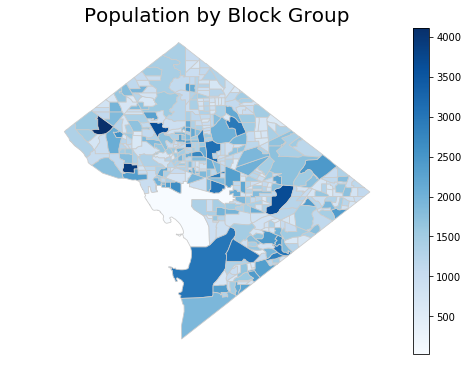

In [102]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Population'
# set the range for the choropleth
vmin, vmax = 120, 220
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
df_pop.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# remove the axis
ax.axis('off')
# add a title
ax.set_title('Population by Block Group', fontdict={'fontsize': '20', 'fontweight' : '3'})

Text(0.5, 1.0, 'Total Crimes by Block Group')

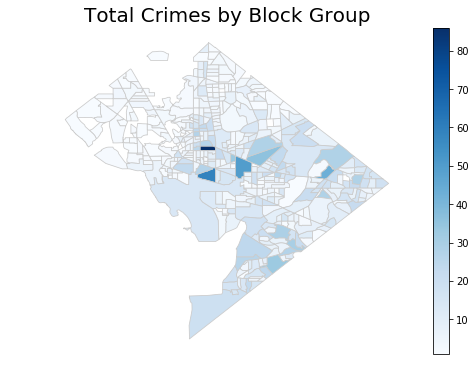

In [99]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Total_Offenses'
# set the range for the choropleth
vmin, vmax = 120, 220
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
crime_pop.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# remove the axis
ax.axis('off')
# add a title
ax.set_title('Total Crimes by Block Group', fontdict={'fontsize': '20', 'fontweight' : '3'})

Text(0.5, 1.0, 'Violent Crime Rate by Block Group')

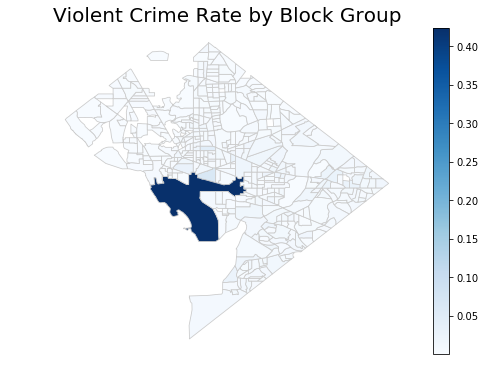

In [103]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Crime_Rate'
# set the range for the choropleth
vmin, vmax = 120, 220
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
crime_pop.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# remove the axis
ax.axis('off')
# add a title
ax.set_title('Violent Crime Rate by Block Group', fontdict={'fontsize': '20', 'fontweight' : '3'})